# Linear Regression - Real Estate Data Set - Regularization

> Joseph P. Vantassel, The University of Texas at Austin

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn import linear_model as lm

## Load Data

In [2]:
# load dataframe
df = pd.read_csv("real_estate.csv")

# convert to numpy
xfeatures = df.iloc[:, 1:-1].to_numpy()
ypredict = df.iloc[:, -1].to_numpy()

# make sure we did the slices correctly
print(f"xfeatures.shape = {xfeatures.shape}")
print(f"ypredict.shape = {ypredict.shape}")

xfeatures.shape = (414, 6)
ypredict.shape = (414,)


## Shuffle and Split

In [3]:
ptrain, pvalid, ptest = 0.7, 0.15, 0.15

# shuffle
rng = np.random.default_rng(1824)
shuffle_idxs = np.arange(len(ypredict))
rng.shuffle(shuffle_idxs)
xfeatures_shuffled = xfeatures[shuffle_idxs]
ypredict_shuffled = ypredict[shuffle_idxs]

# split
start_idx, stop_idx = 0, int(ptrain*len(ypredict))
xfeatures_train, ypredict_train = xfeatures_shuffled[start_idx: stop_idx], ypredict_shuffled[start_idx: stop_idx]
print(xfeatures_train.shape, ypredict_train.shape)


start_idx, stop_idx = stop_idx, stop_idx+int(pvalid*len(ypredict))
xfeatures_valid, ypredict_valid = xfeatures_shuffled[start_idx: stop_idx], ypredict_shuffled[start_idx: stop_idx]
print(xfeatures_valid.shape, ypredict_valid.shape)


start_idx, stop_idx = stop_idx, -1
xfeatures_test, ypredict_test = xfeatures_shuffled[start_idx: stop_idx], ypredict_shuffled[start_idx: stop_idx]
print(xfeatures_test.shape, ypredict_test.shape)


(289, 6) (289,)
(62, 6) (62,)
(62, 6) (62,)


## Normalize

In [4]:
# constant to ensure no divide by zero
eps = 1E-4

def normalize_standardscore(features, means, stds):
    return (features - means)/(stds + eps)
    
def normalize_minmax(features, mins, maxs):
    return (features - mins)/((maxs - mins) + eps)

def normalize_max(features, maxs):
    return features / (maxs + eps)

def rmse(yhat, y):
    return np.sqrt(np.mean(np.power(yhat - y, 2)))

In [18]:
# stats
xmean, xstd = np.mean(xfeatures_train, axis=0), np.std(xfeatures_train, axis=0, ddof=1)
xmin, xmax = np.min(xfeatures_train, axis=0), np.max(xfeatures_train, axis=0)

# training set
x_for_train = np.hstack((
     normalize_standardscore(xfeatures_train, xmean, xstd), # normalize between -3 & +3
     np.log10(normalize_max(xfeatures_train, xmax) + 0.5), # normalize between 0 and 1
     np.exp(normalize_minmax(xfeatures_train, xmin, xmax))
))
xmean_after, xstd_after = np.mean(x_for_train, axis=0), np.std(x_for_train, axis=0)
x_for_train = normalize_standardscore(x_for_train, xmean_after, xstd_after)
y_for_train = ypredict_train

# validation set
x_for_valid = np.hstack((
     normalize_standardscore(xfeatures_valid, xmean, xstd), # normalize between -3 & +3
     np.log10(normalize_max(xfeatures_valid, xmax) + 0.5), # normalize between 0 and 1
     np.exp(normalize_minmax(xfeatures_valid, xmin, xmax))
))
x_for_valid = normalize_standardscore(x_for_valid, xmean_after, xstd_after)
y_for_valid = ypredict_valid

## Train Regularized (or Ridge) Model

This model is different from the purely linear model previously discussed because it includes penalty term for more complex interpreations and should help to reduce the variance in the model we developed previously.

In [21]:
alphas = [0.001, 0.01, 0.1, 0.3, 1, 2, 4, 8, 10]
rmse_train = []
rmse_valid = []
for alpha in alphas:
    rmodel = lm.Ridge(alpha=alpha, fit_intercept=True)
    rmodel_trained = rmodel.fit(x_for_train, y_for_train)
    
    yhat_train = rmodel_trained.predict(x_for_train)
    rmse_train.append(rmse(yhat_train, y_for_train))
    
    yhat_valid = rmodel_trained.predict(x_for_valid)
    rmse_valid.append(rmse(yhat_valid, y_for_valid))

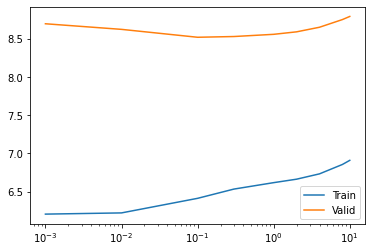

In [23]:
plt.plot(alphas, rmse_train, label="Train")
plt.plot(alphas, rmse_valid, label="Valid")
plt.xscale("log")
plt.legend()
plt.show()